In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation

In [2]:
# Field names for your CSV file - query, docid, rating, rater.  Change these to match your csv headers
field_query = 'topicID'
field_docid = 'docID'
field_gold = 'gold'
field_rating = 'label'
field_rater = 'workerID'

raw_csv_filename = 'trec-20002.csv'
obfuscated_csv_filename = 'trec-20002-obfuscated.csv'
def obfuscate_raters(judgements):
    #Drop NaN ratings and sort by the rater
    groups = judgements.dropna(subset=[field_rating])
    groups = groups.sort_values(by=[field_rater])
    #Obfuscate rater into a letter (for example john.smith@example.com ==> 'A')
    #WARNING, this uses ASCII to iterate and looks strange if you have more than 26 raters!!!!
    last = None
    rater_index = 65
    for index, row in groups.iterrows():
        if last is not None:
            if last[field_rater]!=row[field_rater]:
                rater_index+=1
        last = row
        groups.at[index,field_rater]=chr(rater_index)
    groups = groups.sort_index()
    return groups

def elo_initialize(judgements,noob=1000,hasNIST=True):
    ratings = {}
    if (hasNIST):
        ratings['NIST']=3000
    raters = sorted(judgements[field_rater].unique())
    for rater in raters:
        ratings[rater] = noob
    return ratings

def elo_expected(A, B):
    return 1 / (1 + 10 ** ((B - A) / 400))

def elo(whiteRating,blackRating,whiteResult,blackResult,kwhite=8,kblack=8):
    white = (whiteRating+(kwhite*(whiteResult-elo_expected(blackRating,whiteRating))))
    black = (blackRating+(kblack*(blackResult-elo_expected(whiteRating,blackRating))))
    return white,black

def elo_rate_raters(judgements,noob=1000):
    gb = [field_query,field_docid,field_rating]
    counts = judgements.loc[:,gb].groupby(gb).size().reset_index(name='counts')
    elo_ratings = elo_initialize(judgements,noob,hasNIST=False)
    frame_data = [elo_ratings.copy()]
    frame_num = 1
    for idx,row in counts.iterrows():
        if row['counts']>1:
            #field_query,field_docid,field_rating
            agree = judgements.loc[(judgements[field_query]==row[field_query]) & (judgements[field_docid]==row[field_docid]) & (judgements[field_rating]==row[field_rating])]
            disagree = judgements.loc[(judgements[field_query]==row[field_query]) & (judgements[field_docid]==row[field_docid]) & (judgements[field_rating]!=row[field_rating])]
            len_agree = len(agree[field_rater])
            len_disagree = len(disagree[field_rater])
            for aidx,arow in agree.iterrows():
                w = arow[field_rater]
                for didx,drow in disagree.iterrows():
                    b = drow[field_rater]
                    current_ratings = frame_data[frame_num-1].copy()
                    ws,bs = elo(current_ratings[w],current_ratings[b],1,0)
                    current_ratings[w] = ws
                    current_ratings[b] = bs
                    frame_data.append(current_ratings)
                    frame_num += 1
    print(len(frame_data))                    
    return frame_data

def elo_rate(ratings,gold,rating,rater):
    win_house = 1
    win_rater = 0
    if (gold==rating):
        win_house = 0
        win_rater = 1
    ws,bs = elo(ratings['NIST'],ratings[rater],win_house,win_rater)
    return ws,bs

def elo_rate_row(elo_ratings,idx,row):
    rater = row[field_rater]
    gold = row[field_gold]
    rating = row[field_rating]
    if (gold>-2 and rating>-2):
        ws,bs = elo_rate(elo_ratings,gold,rating,rater)
        #elo_ratings[w] = ws
        elo_ratings[rater] = bs
    return elo_ratings

def elo_rate_raters_vs_trec(judgements):
    elo_ratings = elo_initialize(judgements,noob=1000)
    frame_data = [elo_ratings.copy()]
    frame_num = 1
    for idx,row in judgements.iterrows():
        current_ratings = frame_data[frame_num-1].copy()
        frame_data.append(current_ratings)
        frame_data[frame_num] = elo_rate_row(current_ratings,idx,row)
        frame_num += 1
    print(len(frame_data))
    return frame_data

In [29]:
def animate_elo(frame_data,filename):
    current_ratings = frame_data[len(frame_data)-1]
    fig, ax = plt.subplots()
    rects = plt.bar(range(len(current_ratings)), list(current_ratings.values()), align='center')
    xticks = plt.xticks(range(len(current_ratings)), list(current_ratings.keys()))
    patch = None

    page = 10
    frames = int(len(frame_data)/page)

    lims = ax.get_ylim()
    print(lims)
    
    def animate(i):
        for n in range(i*page,((i+1)*page)-1):
            if(n%1000==0):
                print(n)
            elo_ratings = frame_data[n]
            for rect, rater in zip(rects, elo_ratings):
                h = elo_ratings[rater]
                rect.set_height(h)
                if (h<0):
                    c = (h/lims[0])
                    rect.set_color((c, 1/9, 1/9, 1))
                else:
                    c = (h/lims[1])
                    rect.set_color((1/9, 1/9, c, 1))
        return rects


    #ani = animation.FuncAnimation(fig, animate, 10, interval=6, repeat=False, blit=True)
    ani = animation.FuncAnimation(fig, animate, frames, interval=3, repeat=False, blit=True)

    ani.save(filename, dpi=128)

    plt.show()

In [4]:
csv_data = pd.read_csv(raw_csv_filename,header=[0],encoding='utf-8')
judgement_data = obfuscate_raters(csv_data)

5824
(-11439.598057072442, 3687.59990747964)
0
0
0
1000
2000
3000
4000
5000


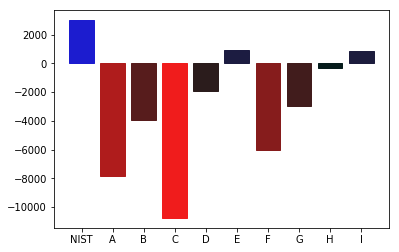

In [30]:
frame_data = elo_rate_raters_vs_trec(judgement_data)
animate_elo(frame_data,"movies/elo.mp4")

4145
(-8288.462213683631, 10283.004018681864)
0
0
0
1000
2000
3000
4000


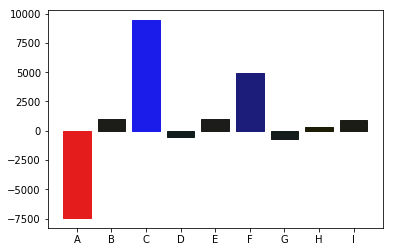

In [31]:
frame_data = elo_rate_raters(judgement_data)
animate_elo(frame_data,"movies/elo2.mp4")

In [38]:
all_csv_filename = 'trec-20002-top-108.csv'

In [40]:
csv_data = pd.read_csv(all_csv_filename,header=[0],encoding='utf-8')

In [45]:
workers = csv_data.workerID.unique()

29864
(-56967.597892917816, 5855.599899662753)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


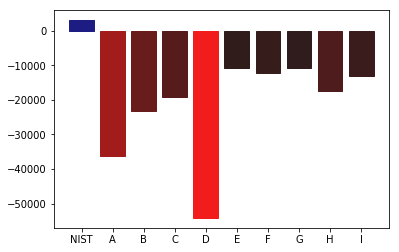

23626
(-38218.798102144814, 4962.799909625944)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000


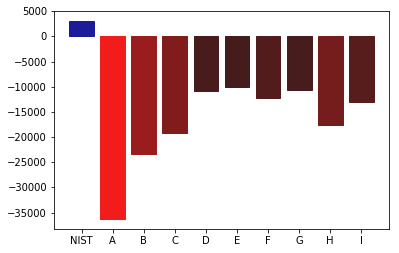

20037
(-24602.39771487789, 4314.399891184661)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


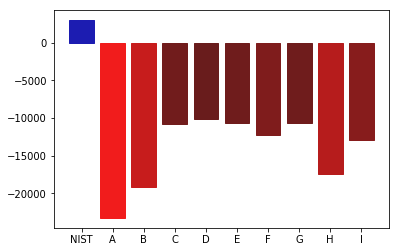

18180
(-20293.197878692332, 4109.199898985349)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


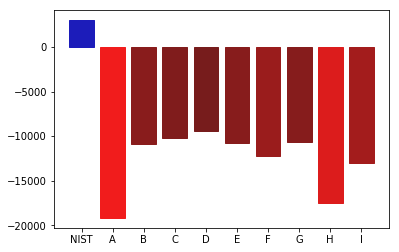

16783
(-18537.59796702957, 4025.5999031918846)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


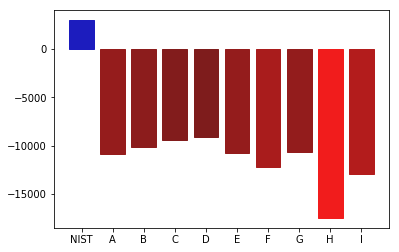

15395
(-13783.197981541452, 3799.1999038829263)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000


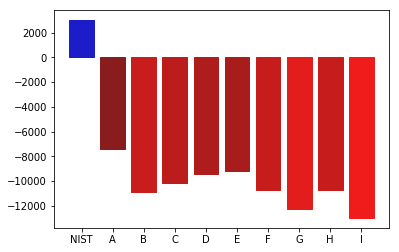

14479
(-13035.597791507349, 3763.5998948336833)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


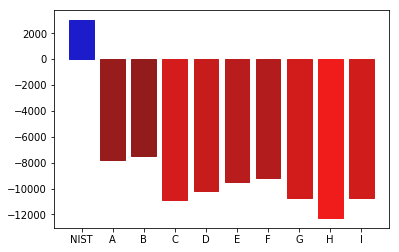

13697
(-11557.197835375147, 3693.199896922626)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


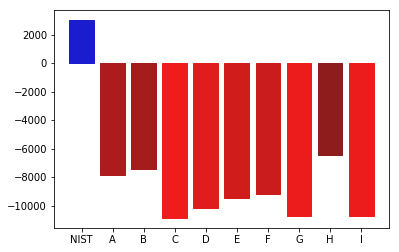

13030
(-11439.598065080654, 3687.5999078609834)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


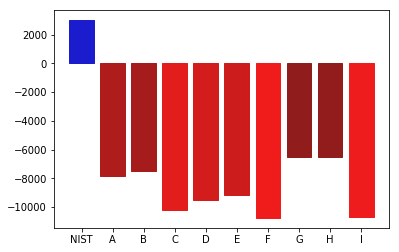

12445
(-11439.598065080654, 3687.5999078609834)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


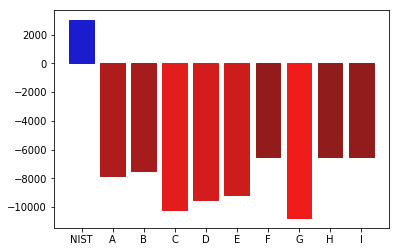

11800
(-11439.598065080654, 3687.5999078609834)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


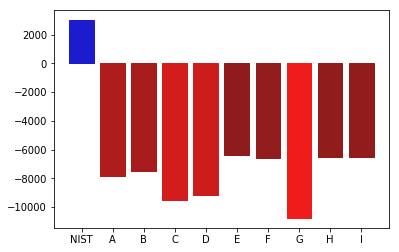

11169
(-10095.597583296492, 3623.599884918881)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


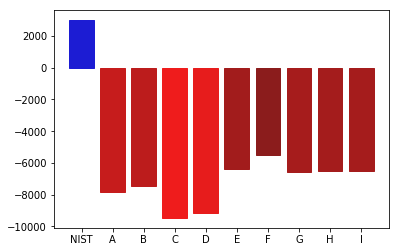

In [57]:
for i in range(0,12):
    group = workers[i:i+9]
    judgement_data = obfuscate_raters(csv_data[csv_data['workerID'].isin(group)])
    frame_data = elo_rate_raters_vs_trec(judgement_data)
    animate_elo(frame_data,"movies/elo_group_"+str(i)+".mp4")

6891
(-12958.045009021484, 10811.739643176703)
0
0
0
1000
2000
3000
4000
5000
6000


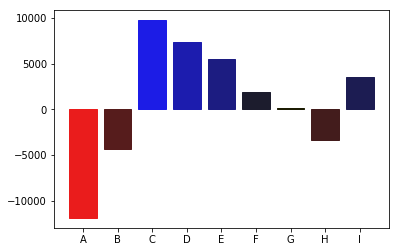

4148
(-6189.213473942319, 5679.817750761279)
0
0
0
1000
2000
3000
4000


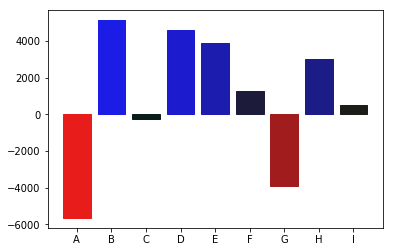

2578
(-4453.066808241737, 6210.724449104203)
0
0
0
1000
2000


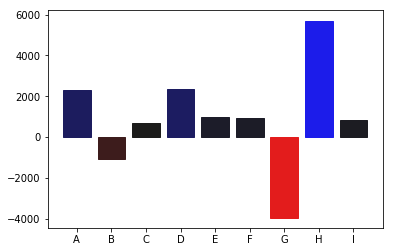

2377
(-4121.956288456583, 5494.710594052494)
0
0
0
1000
2000


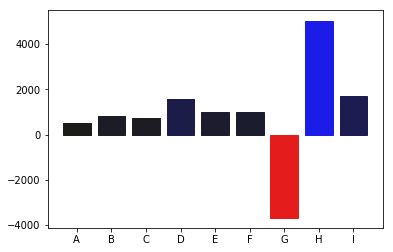

4084
(-9243.463872730897, 8958.467142590016)
0
0
0
1000
2000
3000
4000


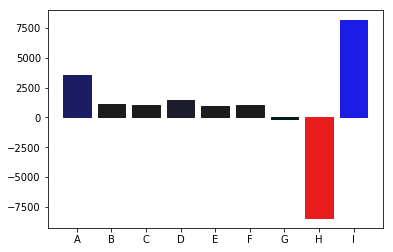

1431
(-1776.4040824779022, 3611.2270237261882)
0
0
0
1000


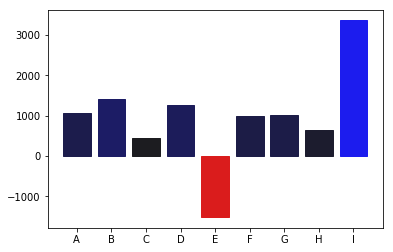

558
(-271.75391138626736, 1830.6681928800435)
0
0
0


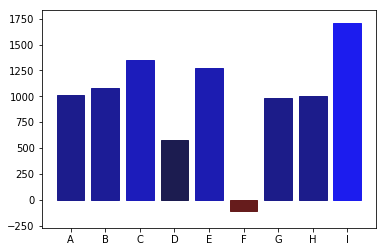

543
(-260.8050329696422, 1845.8970529278395)
0
0
0


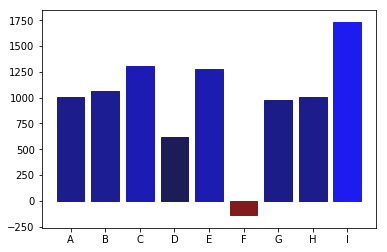

460
(0.0, 1457.184502840705)
0
0
0


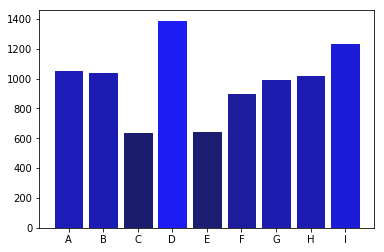

398
(0.0, 1550.3396325094384)
0
0
0


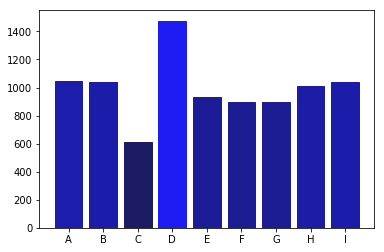

339
(0.0, 1487.0331022170235)
0
0
0


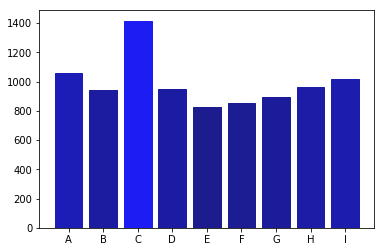

454
(0.0, 1679.4125547395201)
0
0
0


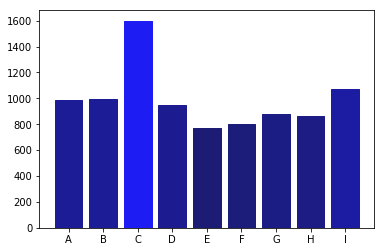

In [58]:
for i in range(0,12):
    group = workers[i:i+9]
    judgement_data = obfuscate_raters(csv_data[csv_data['workerID'].isin(group)])
    frame_data = elo_rate_raters(judgement_data)
    animate_elo(frame_data,"movies/elo_group_majoritywins_"+str(i)+".mp4")

In [59]:
#frame_data = elo_rate_raters(csv_data)
#animate_elo(frame_data,"movies/elo_all.mp4")

104